# <font color="orange">Fine-tunning с использованием библиотеки HuggingFace</font>

## Какой эксперимент здесь проводится.  

- Берем набор текстов (5 000) на русском языке на различные темы (политика, спорт, культура, пр.), которые были векторизованы под определенную модель (<font color="lightgreen">__rubert-tiny2__</font>), или - получены их эмбеддинги (с учетом self-attantion!).  
- Далее, тексты были кластеризованы методом KMeans, где в качестве признаков выступали эмбеддинги, и т.о. были получены псевдо-метки. В итоге, мы получили набор данных: тексты, эмбеддинги, метки.  
- Берем из этих данных _текст_ и _псевдо-метки_ и на них дообучаем модель.   
- Делаем предсказание на дообученной модели, получаем новые псевдо-метки. Заодно оцениваем точность классификации.  
- Таким образом, мы, имея в качестве "истинных" меток псевдо-метки, полученные методом кластеризации KMeans, дообучаем модель и делаем на дообученной модели предсказание.   
- Учитывая, что мы получили метки в результате кластеризации KMeans (классификатор без учителя, работающий на определенном принципе формирования классов), то  интересно взглянуть на то, как модель может дообучиться/подстроиться под данную разметку, показывав хорошую точность.

## Кое-какая теория

__Классификация с учителем на основе нейронных сетей__ — это мощный и гибкий подход, особенно если данные большие и имеют сложную структуру (например, тексты, изображения или временные ряды). Вот обзор основных реализаций нейросетевых классификаторов, их типов и особенностей:

🧠 _1. Простая полносвязная нейронная сеть (MLP — Multi-Layer Perceptron)_  
Где применимо: числовые признаки, табличные данные, базовая текстовая классификация после векторизации (TF-IDF, word2vec).  
Особенности:  
Работает как классические классификаторы, но мощнее при большом количестве признаков.  
Плохо масштабируется на длинные тексты и последовательности без специальной архитектуры.  

📄 _2. Нейросети для текстов: Embedding + RNN/LSTM/GRU/Transformer_  
Где применимо: классификация длинных и сложных текстов.  
Особенности:  
Требует токенизации и индексации текста.  
Обучается с нуля, или использует предобученные эмбеддинги (GloVe, FastText).  

🚀 _3. Transformer-модели (BERT, RoBERTa и др.)_  
Где применимо: высокоточная классификация текстов, особенно с богатым языком (русский, английский).
Особенности:  
Использует предобученные модели.  
Отлично работает на задачах классификации длинных текстов, требует GPU.  

⚙️ _4. Глубокие сверточные сети (CNN)_  
Где применимо: изображение, иногда текст (сжатый), биоинформатика.  

📊 <u>Сравнение с классическими классификаторами</u>  
__KNN, SVC, LR__
Малые/средние данные, табличные
Простота, не требует много данных

__MLP (sklearn)__
Табличные данные, векторизованные тексты
Хорошая альтернатива классике

__LSTM/GRU__
Последовательности, тексты
Учитывает порядок слов

__Transformer__
Сложные тексты, многоклассовая классификация
State-of-the-art, требует вычислений

__CNN__
Изображения, пиксельные данные
Пространственные зависимости  

#### Объяснение ключевых шагов:
1. Загрузка:  
Используем AutoTokenizer и AutoModelForSequenceClassification для загрузки модели и токенизатора cointegrated/rubert-tiny2.
Проверка GPU: В Google Colab автоматически будет использован GPU, если он доступен, с помощью команды torch.device("cuda" if torch.cuda.is_available() else "cpu").
2. Токенизация:  
Тексты токенизируются в формате, подходящем для модели (с добавлением паддинга и обрезкой до максимальной длины 256).  
3. Обучение:  
Используется Trainer из transformers для обучения модели на псевдоразметке с использованием переданных аргументов обучения (TrainingArguments).  
3. Предсказания:  
После обучения модель используется для предсказания новых меток для всех текстов, которые подаются через функцию predict_pseudo_labels.  


# Код

In [ ]:
# !pip install transformers datasets

In [ ]:
# !pip install --upgrade transformers
# !pip show transformers
# print(TrainingArguments.__module__)

# from transformers import TrainingArguments
# import inspect
# print(inspect.signature(TrainingArguments.__init__))

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
# Связь с файлами на Google drıve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Подготовка данных

num_object = 5000 # С каким файлом по объему выбранного текста будем работать
# _________Google Colab___________
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_KMeans_{num_object}.csv'

# __________Локально_____________
# output_file_short = f"./Data/clusters_rubert-tiny2_KMeans_{num_object}.csv"

df = pd.read_csv(output_file, encoding="utf-8") # Читаем файл (текст, эмбеддинги, псевдо-метки)
print(df.head(2))

texts = df['text']  # Исходные тексты
pseudo_labels = df['cluster']  # Псевдораспределения из кластеризации
num_labels = len(set(pseudo_labels))  # Количество классов
print(num_labels)

## Fine-tuning, prediction...

In [ ]:
# Разделение на обучающую и валидационную выборки
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, pseudo_labels, test_size=0.2, random_state=42, stratify=pseudo_labels
)
# stratify=pseudo_labels	- Стратифицированная выборка — сохраняет пропорции классов в обучении и валидации

In [ ]:
# Загрузка модели и токенизатора
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

In [ ]:
# Проверка на наличие GPU в Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
# help(TrainingArguments)

In [ ]:
# Настройка аргументов обучения
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=False,
    report_to="none",
    fp16=True,  # Использование 16-битной точности для ускорения на GPU
    gradient_accumulation_steps=2  # Для больших данных увеличиваем градиентный аккумулятор
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
# Запуск обучения
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.966200,0.853402
2,0.708600,0.677693
3,0.606800,0.586215
4,0.518700,0.537141
5,0.501700,0.522691


TrainOutput(global_step=625, training_loss=0.6804745330810547, metrics={'train_runtime': 58.9271, 'train_samples_per_second': 339.402, 'train_steps_per_second': 10.606, 'total_flos': 73818992640000.0, 'train_loss': 0.6804745330810547, 'epoch': 5.0})

In [ ]:
# Предсказание новых псевдо-меток
def predict_pseudo_labels(texts):
  # tokenizer ожидает список строк, а у нас он имеет тип "pandas.Series"
  # поэтому преобразуй Series в список -> .tolist()
  texts_list = df['text'].tolist()

  # Настройки
  batch_size = 128
  all_preds = []

  # Обработка батчами
  for i in tqdm(range(0, len(texts_list), batch_size)):
    batch_texts = texts_list[i:i + batch_size]

    # Токенизация батча
    tokenized = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=256
    )

    tokenized = {k: v.to(device) for k, v in tokenized.items()}

    # Предсказание
    with torch.no_grad():
        outputs = model(**tokenized)
        predictions = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(predictions.cpu().numpy())
  # Финальный массив псевдо меток
  n_pseudo_labels = np.array(all_preds)

  return n_pseudo_labels

  print("Получено меток:", len(n_pseudo_labels))

In [ ]:
 new_pseudo_labels = predict_pseudo_labels(texts)
 new_pseudo_labels

100%|██████████| 40/40 [00:07<00:00,  5.57it/s]


array([8, 7, 3, ..., 4, 4, 0])

In [ ]:
# Подсчет количества по pseudo_labels
counts_pseudo = pd.Series(pseudo_labels).value_counts().sort_index()
counts_pseudo

,count
cluster,
0,246
1,535
2,404
3,961
4,492
5,412
6,600
7,440
8,542


In [ ]:
# Подсчет количества по новым меткам
counts = pd.Series(new_pseudo_labels).value_counts().sort_index()
counts

,count
0,213
1,513
2,401
3,993
4,498
5,397
6,605
7,445
8,571
9,364


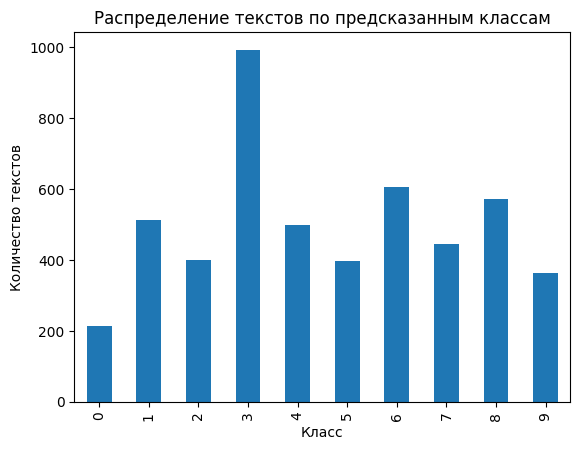

In [ ]:
import matplotlib.pyplot as plt

counts.plot(kind='bar')
plt.xlabel("Класс")
plt.ylabel("Количество текстов")
plt.title("Распределение текстов по предсказанным классам")
plt.show()

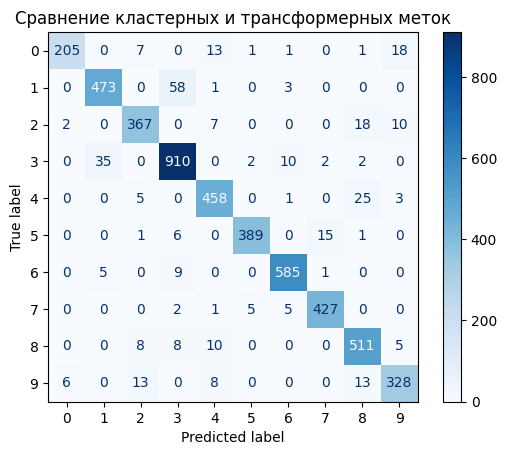

In [ ]:
# Матрица ошибок (Confusion Matrix):
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(pseudo_labels, new_pseudo_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Сравнение кластерных и трансформерных меток")
plt.show()

In [ ]:
cm

array([[205,   0,   7,   0,  13,   1,   1,   0,   1,  18],
       [  0, 473,   0,  58,   1,   0,   3,   0,   0,   0],
       [  2,   0, 367,   0,   7,   0,   0,   0,  18,  10],
       [  0,  35,   0, 910,   0,   2,  10,   2,   2,   0],
       [  0,   0,   5,   0, 458,   0,   1,   0,  25,   3],
       [  0,   0,   1,   6,   0, 389,   0,  15,   1,   0],
       [  0,   5,   0,   9,   0,   0, 585,   1,   0,   0],
       [  0,   0,   0,   2,   1,   5,   5, 427,   0,   0],
       [  0,   0,   8,   8,  10,   0,   0,   0, 511,   5],
       [  6,   0,  13,   0,   8,   0,   0,   0,  13, 328]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(pseudo_labels, new_pseudo_labels))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       246
           1       0.92      0.88      0.90       535
           2       0.92      0.91      0.91       404
           3       0.92      0.95      0.93       961
           4       0.92      0.93      0.93       492
           5       0.98      0.94      0.96       412
           6       0.97      0.97      0.97       600
           7       0.96      0.97      0.96       440
           8       0.89      0.94      0.92       542
           9       0.90      0.89      0.90       368

    accuracy                           0.93      5000
   macro avg       0.93      0.92      0.93      5000
weighted avg       0.93      0.93      0.93      5000



In [ ]:
# Метрики согласованности:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(pseudo_labels, new_pseudo_labels)
ami = adjusted_mutual_info_score(pseudo_labels, new_pseudo_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Adjusted Mutual Info (AMI): {ami:.4f}")

Adjusted Rand Index (ARI): 0.8553
Adjusted Mutual Info (AMI): 0.8587


In [ ]:
# Добавляем столбец  "cluster" в df_subset
df = df.copy()  # Создаем независимую копию
df["cluster_2"] = list(new_pseudo_labels)  # Теперь можно безопасно изменять
df.head()

,text,embedding,cluster,cluster_2
0,Заместитель председателяnправительства РФnСерг...,"[0.07518719, -0.0055617844, 0.014240301, -0.04...",8,8
1,Матч 1/16 финала Кубка России по футболу был п...,"[0.00035189706, -0.04810312, -0.020328153, -0....",7,7
2,Форвард «Авангарда» Томаш Заборский прокоммент...,"[0.04424202, 0.00478189, -0.02290487, -0.04921...",3,3
3,Главный тренер «Кубани» Юрий Красножан прокомм...,"[0.047330584, 0.031060353, 0.0015447184, -0.03...",3,3
4,Решением попечительского совета владивостокско...,"[0.07092083, -0.05181958, -0.01780495, -0.0265...",8,8


In [ ]:
# Cохранение (текст, эмбеддинги, метки, метки)

# Google Colab
output_file = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_KMeans_{num_object}_fine.csv'
# Локально
# output_file_short = f"./Data/clusters_rubert-tiny2_KMeans_fine_{num_object}.csv"

df.to_csv(output_file, index=False, encoding="utf-8")
print(f"✅ Кластеры сохранены в {output_file}.")

✅ Кластеры сохранены в /content/drive/My Drive/Example_ML/classification_text/Classifiers/Experiments/After_clastering/clusters_rubert-tiny2_KMeans_5000_fine.csv.


## <font color='lightgreen'>_-> Визуализация эмбеддингов и кластеров до дообучения._</font>

In [ ]:
# Признаки (эмбеддинги)
X_old = np.stack(df['embedding'].to_numpy()) # Преобразуем списка с эмбеддингами в массив чисел
# Метки
y_old = pseudo_labels

print(X_old.shape, X_old.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y_old.shape, y_old.dtype) # Должно быть (количество образцов, ) Должно быть int64

(5000, 312) float32
(5000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


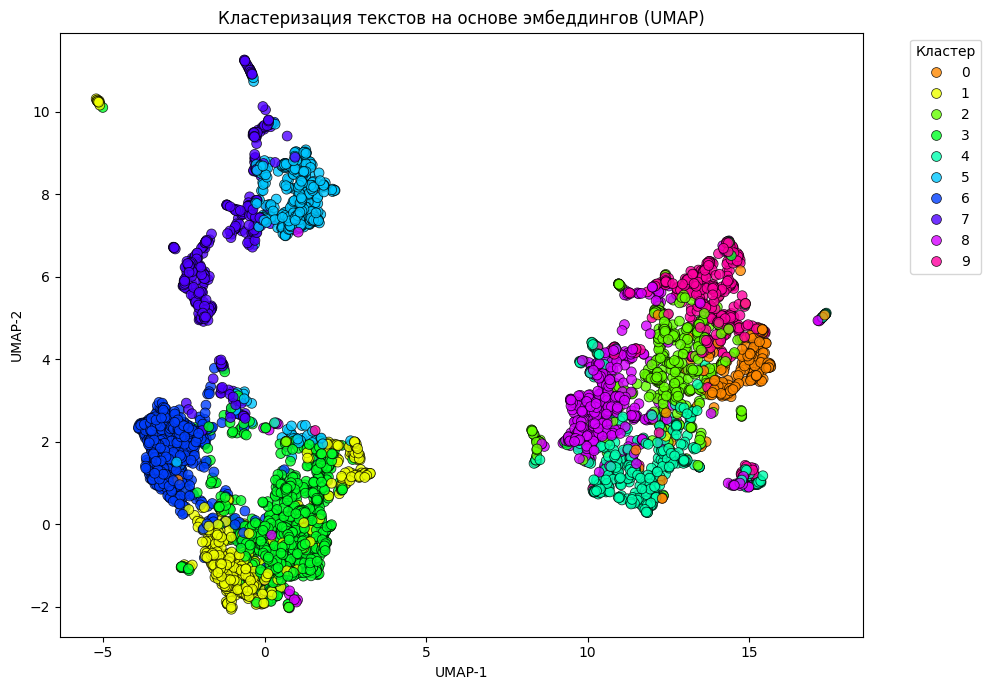

In [ ]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import pandas as pd

# 1. UMAP проекция
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42) # n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре),  min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы), metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X_old)

# 2. Подготовка DataFrame для визуализации
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': y_old
})
# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y_old)))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов до дообучения")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## <font color='lightgreen'>_-> Визуализация эмбеддингов и кластеров после дообучения._</font>

In [ ]:
output_file_new = "/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/clusters_rubert-tiny2_KMeans_fine_1000.csv"
df_subset_new = pd.read_csv(output_file_new, encoding="utf-8") # Читаем файл
print(df_subset_new.head(2))

                                                text  \
0  Военный конфликт в Ливии развивается стремител...   
1  Политика премьер-министра Великобритании Дэвид...   

                                           embedding  cluster  cluster_2  
0  [ 9.36453864e-02 -2.63940971e-02  2.55011357e-...        2          8  
1  [ 8.71069077e-03  3.12048644e-02  1.30712045e-...        7          8  


In [ ]:
type(df_subset_new["embedding"].iloc[0])

numpy.ndarray

In [ ]:
# Количественное распределение текстов по кластерам:
from collections import Counter
counts_cluster = Counter(df_subset_new['cluster_2'])
counts_cluster

Counter({8: 332, 9: 453, 1: 148, 7: 28, 6: 26, 5: 8, 3: 5})

Какова кластеризация после fıne-tunning и классификации моделью `rubert-tiny2`

In [ ]:
# Эмбеддинги
X_new = np.vstack(df["embedding"].values) # Преобразуем в numpy-массив
# Метки
y_new = df['cluster_2']

print(X_new.shape, X_new.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y_new.shape, y_new.dtype) # Должно быть (количество образцов, ) Должно быть int64

(5000, 312) float32
(5000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


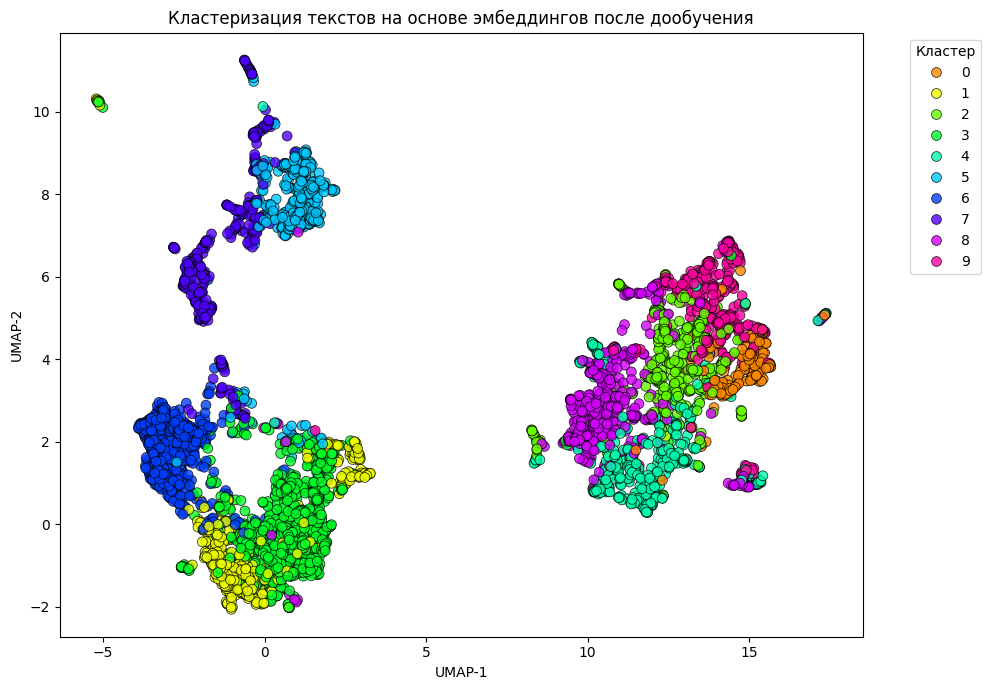

In [ ]:
# 1. UMAP проекция
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42) # n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре),  min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы), metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X_new)

# 2. Подготовка DataFrame для визуализации
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': y_new
})
# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y_new)))
sns.scatterplot(data=df_plot, x='x', y='y', hue='label', palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов после дообучения")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()